# Speech understanding
## 1. Introduction
This notebook is for playing with audio files. Understanding the fundamental speech frequency and other well known terms in Automatic Speech Recognition (ASR) like Mel-Frequency Cepstral Coefficients (MFCCs), Gammatone-Frequency Cepstral Coefficients (GFCC), Bark-Frequency Cepstral Coefficients (BFCC) and so on.
## 2. Audio import and playing audio

In [24]:
%matplotlib widget

import os
import audioread
import librosa
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from librosa.display import specshow, waveplot
from IPython.display import display as iDisplay
from IPython.display import Audio as iAudio
import seaborn as sns
import ipywidgets

from scipy.signal import spectrogram
from pydub import AudioSegment, effects

sns.set()

audio_book_path = r'./input/cienmejorespoesias_000_menendezypelayo_64kb.mp3'
noise_path = r'./input/city4_short.mp3'

class AudioManager:
    def __init__(self, path=''):
        self.path = path
        self.raw  = None
        self.norm = None
        self.ext = os.path.splitext(self.path)[1][1:]
        self.samples = None
        self.n_channels  = None
        self.sample_rate = None
        self.duration    = None
        if not self.path == '':
            self.load()
            
    def __add__(self, audio_manager):
        ret_value = deepcopy(self)
        ret_value.raw = ret_value.raw.overlay(audio_manager.raw)
        ret_value.norm = effects.normalize(ret_value.raw)
        ret_value.get_samples()
        
        return ret_value
        
    def get_samples(self):
        self.samples = np.array(self.raw.get_array_of_samples(), dtype=np.float32)
        
    def load(self):
        with audioread.audio_open(self.path) as fId:
            self.n_channels  = fId.channels
            self.sample_rate = fId.samplerate
            self.duration    = fId.duration
        self.raw = AudioSegment.from_file(self.path, self.ext)
        if self.n_channels != 1:
            print('Audio ' + self.path + ' contains more than one channel. Converting to mono')
            self.raw = self.raw.set_channels(1)
            self.n_channels = 1
            self.sample_rate = int(self.sample_rate/2)
        self.norm = effects.normalize(self.raw)
        self.get_samples()
        #self.samples, sr = librosa.load(self.path)
        #print('LibRosa Sampling rate '+ str(sr) + '\n' +
        #      'AudioRead Sampling rate ' + str(self.sample_rate))
        
    def player(self):
        return self.raw
    
    def plot_spectrogram(self, plot_type='log'):
        plot_types = ['log','linear']
        if not plot_type in plot_types:
            raise Exception('Unknown plot_type: Allowed ' + str(plot_types))
        fig_handler = plt.figure(dpi= 80, facecolor='w', edgecolor='k')
        db_values = librosa.amplitude_to_db(np.abs(librosa.stft(self.samples,n_fft=2048)), ref=np.max)
        ax_handler = plt.subplot(4, 2, 1)
        specshow(db_values, sr=self.sample_rate, y_axis=plot_type, cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title(plot_type + '-frequency power spectrogram')
        fig_handler.canvas.layout.width = '500px'
        
    def plot_wave(self):
        fig_handler = plt.figure(dpi= 80, facecolor='w', edgecolor='k')
        ax_handler = plt.subplot(4, 2, 1)
        if len(self.samples) > 10**5:
            waveplot(self.samples[:int(10**5)], sr=self.sample_rate)
        else:
            waveplot(self.samples, sr=self.sample_rate)
        fig_handler.canvas.layout.width = '500px'
        

In [2]:
# Loaing audio book
audio_book = AudioManager(audio_book_path)

# Loaing and normalizing noise audio
noise = AudioManager(noise_path)

Audio ./input/city4_short.mp3 contains more than one channel. Converting to mono


### 2.1 Players and spectrograms

In [3]:
audio_book.player()

In [4]:
noise.player()

In [5]:
audio_book.plot_spectrogram('linear')
audio_book.plot_wave()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
noise.plot_spectrogram('linear')
noise.plot_wave()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 3. Audio combination

In [32]:
#noise.raw = noise.raw + 8
sum_audio = audio_book + noise
sum_audio.player()

In [8]:
sum_audio.plot_spectrogram('linear')
sum_audio.plot_wave()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 4. Checking if spectrogram for noise signal is well calculated

In [14]:
import scipy
import numpy as np

# Generating a pure tone in centered in f0 with the same rate as the noise signal
time_sim = np.arange(0,120,1/noise.sample_rate)
f0 = 5500
signal = np.sin(2*np.pi*f0*time_sim)
plt.plot(signal)

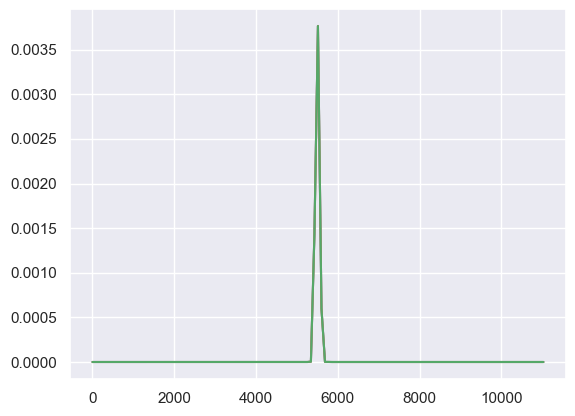

In [27]:
# Ploting FFT for chcking that the tone is centered in the targeted frequency
f, Pxx = scipy.signal.welch(signal, fs = noise.sample_rate)
plt.plot(f,Pxx)
iDisplay(plt.gcf())

In [16]:
# Combining signals in time domain
input_signal = noise.samples
input_signal[0:len(signal)] += 10*signal

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

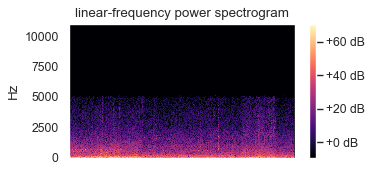

In [28]:
# Computing spectrogram with scipy and ploting with LibRosa
n_samples_window = 2048
freq, time, stft = scipy.signal.spectrogram(
    input_signal, fs=noise.sample_rate, 
    window=scipy.signal.get_window('hann', n_samples_window), 
    #nperseg=None, 
    noverlap=int(n_samples_window/2), nfft=n_samples_window, 
    #detrend='constant', 
    return_onesided=True, scaling='spectrum', axis=-1, mode='complex')

db_values = librosa.amplitude_to_db(np.abs(stft))
fig_handler = plt.figure(figsize=(10,10), dpi= 80, facecolor='w', edgecolor='k')
ax_handler = plt.subplot(4, 2, 1)
specshow(db_values, sr=noise.sample_rate, y_axis='linear',  cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('linear' + '-frequency power spectrogram')

In the figure above the pure tone can e seen in 5.5KHz so noise signal has arround 5KHz badwith
## 5. Mel Frecuency Cepstral Coefficient (MFCC)
Refs: http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

MFCCs are coefficients intended to accurately represent the envelope of the short time power spectrum produced by the vocal tract (tonge, teeth, etc.) when humans speak. This envelope allows us understanding the speech phenomenae.
MFCCs are a feature widely used in automatic speech and speaker recognition. They were introduced by Davis and Mermelstein in the 1980's, and have been state-of-the-art ever since.
### 5.1 Steps summary
* Frame the signal into short frames.
* For each frame calculate the periodogram estimate of the power spectrum.
* Apply the mel filterbank to the power spectra, sum the energy in each filter.
* Take the logarithm of all filterbank energies.
* Take the DCT of the log filterbank energies.
* Keep DCT coefficients 2-13, discard the rest.

## 5.2 Splitting signal in frames
An audio signal is constantly changing, so to simplify things we assume that on short time scales the audio signal doesn't change much (when we say it doesn't change, we mean statistically i.e. statistically stationary, obviously the samples are constantly changing on even short time scales). This is why we frame the signal into 20-40ms frames. If the frame is much shorter we don't have enough samples to get a reliable spectral estimate, if it is longer the signal changes too much throughout the frame.

22050